In [1]:
import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

tf.__version__

'2.4.1'

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# flatten image data <- NOT FOR CNN
#x_train = x_train.reshape(-1, 784)
#x_test = x_test.reshape(-1, 784)

# For CNNs  ->
###   DIFFERENT RESHAPE  ### 
### We here need the dimensions of the image plus a channel, e.g. for RGB images one have 3 channels ###
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize to a scale between 0 and 1
x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (one-hot notation)
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


Text(0.5, 1.0, 'Label for image 31 is: 0')

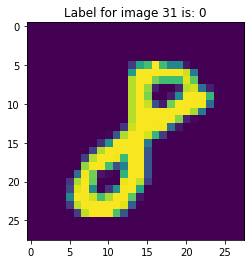

In [4]:
i = 31
plt.imshow(x_train[i].reshape(28, 28)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(y_train[i])))

## GPU and CPU settings
If GPU is not available, comment out the bottom block.

In [8]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.compat.v1.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Device mapping: no known devices.


In [9]:
########## HYPER PARAMETERS
batch_size = 128
epochs = 10
optimizer = tf.keras.optimizers.RMSprop()
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 5)         50        
_________________________________________________________________
flatten (Flatten)            (None, 3380)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                33810     
Total params: 33,860
Trainable params: 33,860
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 12s 24ms/step - loss: 0.6831 - accuracy: 0.8310 - val_loss: 0.2408 - val_accuracy: 0.9315
Epoch 2/10
469/469 [==============================] - 11s 24ms/step - loss: 0.2125 - accuracy: 0.9391 - val_loss: 0.1604 - val_accuracy: 0.9560
Epoch 3/10
469/469 [==============================] - 11s 24ms/step - loss: 0.1430 - accuracy:

# Plot training and test accuracy

In [10]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))


 Summary of the precision, recall, F1 score for each class:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


 Confusion matrix: 
[[ 970    0    0    0    0    2    2    3    3    0]
 [   0 1129    2    1    0    0    2    0    1    0]
 [   2    3 1011    1    1    0    1    7    5    1]


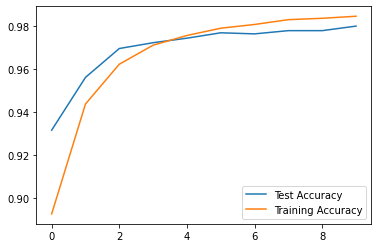

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'], label="Test Accuracy")
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.legend()

In [13]:
# save model
model.save("myModelCNN.h5")